# FULL Anomaly Detection Coverage on Real Businses Problem with AWS SageMaker

This notebook shows how to train an Amazon SageMaker model to flag anomalous Medicare claims and target them for further investigation on suspicion of fraud. THe solution is to create a model to flag suspicious claims.

The difference between data normality and abnormality is often not clear. Anomaly detection methods could be application-specific. For example, in clinical data, a small deviation could be an outlier, but in a marketing application, you need a significant deviation to justify an outlier.
Noise in data may appear as deviations in attribute values or missing values. Noise may hide an outlier or flag deviation as an outlier.
Providing clear justification for an outlier may be difficult

#### Overview
- Data EDA 
- Data PreProcessing/Cleaning
- Feature engineering on text columns using the word2vec
- Perform Principal Components Analysis (PCA) model to the preprocessed dataset
- Score the entire dataset
- Apply a threshold to the scores to identify any suspicious or anomalous claims.

In [126]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import time                                       #provides various time-related functions
import warnings                                   #allows you to handle all warnings with the standard logging
warnings.filterwarnings(action = 'ignore')        #warnings filter controls whether warnings are ignored, displayed

import io                                         #interface to access files and streams
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv
import shutil
import tqdm
import urllib.request
from tqdm import notebook
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
from IPython.display import Image

import cv2

import sagemaker          
import sagemaker.amazon.common as smac            #provides common function used for training and deploying machine-learned models on Amazon SageMaker
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split #Quick utility to split data into train and test set

import gensim                                     #topic modelling library for Python that provides access to Word2Vec
import columnize                                  #format a simple (i.e. not nested) list into aligned columns.
from gensim.models import Word2Vec                #topic modelling library for Python that provides access to Word2Vec
from sklearn.manifold import TSNE                 #containing T-SNE algorithms used to project high dimensional space into lower dimesional space
from numpy.linalg import inv                      #Compute the dot product of two or more arrays in a single function call
import scipy.stats                                #contains a large number of probability distributions for statistical analysis
import scipy as sp                                #collection of mathematical algorithms
import seaborn as sns                             #data visualization library based on matplotlib
import mxnet as mx                                #open-source deep learning software framework, used to train, and deploy deep neural networks.

### 1. Preparation (Specifying Sagemaker roles)

In [5]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'PCA_anomaly'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000002040B4AE888>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : PCA_anomaly
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 2. Load Data
The dataset is the publicly available Basic Stand Alone (BSA) Inpatient Public Use File (PUF). Dataset can be directly donwloaded from here [Link](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip)

This post uses a Medicare inpatient claims dataset from 2008. The dataset is the publicly available Basic Stand Alone (BSA) Inpatient Public Use File (PUF) named CMS 2008 BSA Inpatient Claims PUF.

The instructions to download the dataset are available in the post’s Jupyter Notebook. For more information, see the GitHub repo. The dataset contains a primary claim key indexing the records and six analytic variables. There are also some demographic and claim-related variables. 

This is a minimal dataset in terms of features. Some desired features, such as facility zip codes, are missing. You can add more data to build a set of features to continue to improve the accuracy of this solution.

In [6]:
# Check to see if there are any meaningful names for column labels
colnames = pd.read_csv("./data/anomaly-detection/ColumnNames.csv")
colnames[colnames.columns[-1]] = colnames[colnames.columns[-1]].map(lambda x: x.replace('"','').strip())

display(colnames)

,Column Label,"""Column Name"""
0,IP_CLM_ID,Encrypted PUF ID
1,BENE_SEX_IDENT_CD,Beneficiary gender code
2,BENE_AGE_CAT_CD,Beneficiary Age category code
3,IP_CLM_BASE_DRG_CD,Base DRG code
4,IP_CLM_ICD9_PRCDR_CD,ICD9 primary procedure code
5,IP_CLM_DAYS_CD,Inpatient days code
6,IP_DRG_QUINT_PMT_AVG,DRG quintile average payment amount
7,IP_DRG_QUINT_PMT_CD,DRG quintile payment amount code


In [7]:
# read claims data file
df_cms_claims_data = pd.read_csv('./data/anomaly-detection/2008_BSA_Inpatient_Claims_PUF.csv')
df_cms_claims_data.columns = colnames[colnames.columns[-1]].ravel()
pd.set_option('display.max_columns', 500)

# print the shape of the data file
print('Shape:', df_cms_claims_data.shape)

# Top few rows
display(df_cms_claims_data.head())

# Data object
display(df_cms_claims_data.describe())

# Datatype for each column
display(df_cms_claims_data.dtypes)

# Any missing value
display(df_cms_claims_data.isnull().mean())

Shape: (588415, 8)


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
0,IP-000022CE4125DBE7,2,4,3,31.0,4,86240,4
1,IP-0000417F50942D90,2,5,199,NaN,2,3447,2
2,IP-0000865F5457AC0E,1,1,119,54.0,4,34878,5
3,IP-00009789630AF474,2,2,128,NaN,2,3007,2
4,IP-0000C9D229B79D36,2,2,236,70.0,1,3352,2


,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
count,588415.000000,588415.000000,588415.000000,311869.000000,588415.000000,588415.000000,588415.000000
mean,1.561165,3.574610,140.202393,59.683832,2.516377,9312.621422,2.999444
std,0.496245,1.805788,79.686699,29.207527,0.972758,10482.707298,1.414880
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,82.000000,38.000000,2.000000,4008.000000,2.000000
50%,2.000000,4.000000,123.000000,54.000000,2.000000,6352.000000,3.000000
75%,2.000000,5.000000,200.000000,86.000000,3.000000,10760.000000,4.000000
max,2.000000,6.000000,311.000000,99.000000,4.000000,329467.000000,5.000000


Encrypted PUF ID                        object
Beneficiary gender code                  int64
Beneficiary Age category code            int64
Base DRG code                            int64
ICD9 primary procedure code            float64
Inpatient days code                      int64
DRG quintile average payment amount      int64
DRG quintile payment amount code         int64
dtype: object

Encrypted PUF ID                       0.000000
Beneficiary gender code                0.000000
Beneficiary Age category code          0.000000
Base DRG code                          0.000000
ICD9 primary procedure code            0.469985
Inpatient days code                    0.000000
DRG quintile average payment amount    0.000000
DRG quintile payment amount code       0.000000
dtype: float64

You might have observed some 'NaN' and mean value(0.469985) for ICD9 primary procedure code in print results above.
We need fix to 'NaN' in ICD9 primary procedure code.

### 3. Data Feature Engineering

##### Missing values
Based on results of isnull.mean(), it is clear that 'ICD9 primary procedure code' has a non zero mean and it is so because it has NaN values. The NaN values corresponds to "No Procedure Performed" in the in the 'ICD9 primary procedure code' dictionary. Let's replace NaN values with a numeric code for "No Procedure Performed".

In [8]:
#Fill NaN with -1 for "No Procedure Performed"
procedue_na = -1
df_cms_claims_data['ICD9 primary procedure code'].fillna(procedue_na, inplace = True)

#convert procedure code from float to int64
df_cms_claims_data['ICD9 primary procedure code'] = df_cms_claims_data['ICD9 primary procedure code'].astype(np.int64)


#check count of null values to ensure dataframe is updated
display(df_cms_claims_data.isnull().mean())

Encrypted PUF ID                       0.0
Beneficiary gender code                0.0
Beneficiary Age category code          0.0
Base DRG code                          0.0
ICD9 primary procedure code            0.0
Inpatient days code                    0.0
DRG quintile average payment amount    0.0
DRG quintile payment amount code       0.0
dtype: float64

##### Categorical variables

##### (1) Gender

,bene_sex_ident_cd,Beneficiary gender
0,1,Male
1,2,Female


Text(0, 0.5, 'Percentage claims')

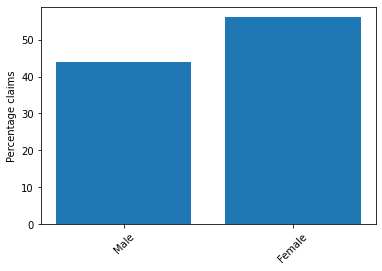

In [10]:
# Since gender is already binary and coded as 1 for Male and 2 for Female
# read gender dictionary csv file
dict_gender = pd.read_csv("./data/anomaly-detection/Gender.csv")
dict_gender.columns = dict_gender.columns.to_series().apply(lambda x: x.strip())
display(dict_gender)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_gender_counts = dict_gender.set_index('bene_sex_ident_cd').join( df_cms_claims_data['Beneficiary gender code'].value_counts() )
tmp_gender_counts['percentage'] = tmp_gender_counts['Beneficiary gender code']/tmp_gender_counts['Beneficiary gender code'].sum()*100

# project gender distribution in the dataset on the bar graph
plt.bar(tmp_gender_counts.index, tmp_gender_counts['percentage'].tolist());
plt.xticks(tmp_gender_counts.index, tmp_gender_counts['Beneficiary gender'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

##### (2) AgeGroup 

,BENE_AGE_CAT_CD,Age Group
0,1,Under_65
1,2,65_to_69
2,3,70_to_74
3,4,75_to_79
4,5,80_to_84
5,6,85_and_Older


Text(0, 0.5, 'Percentage claims')

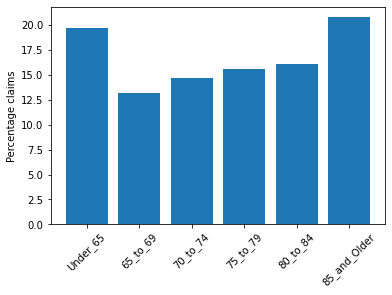

In [11]:
#read AgeGroup csv file into a pandas dataframe
dict_age_group = pd.read_csv("./data/anomaly-detection/AgeGroup.csv", sep=',')
dict_age_group.columns = dict_age_group.columns.to_series().apply(lambda x: x.strip())
display(dict_age_group)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_age_sorted_counts = dict_age_group.set_index('BENE_AGE_CAT_CD').join( df_cms_claims_data['Beneficiary Age category code'].value_counts() )
tmp_age_sorted_counts['percentage'] = tmp_age_sorted_counts['Beneficiary Age category code']/tmp_age_sorted_counts['Beneficiary Age category code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.bar(tmp_age_sorted_counts.index, tmp_age_sorted_counts['percentage'].tolist());
plt.xticks(tmp_age_sorted_counts.index, tmp_age_sorted_counts['Age Group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

##### Text variables

All physician and hospital claims include one or more diagnosis codes. The ICD-9-CM diagnosis coding system is used since October, 2012.

Hospital inpatient claims also include one or more procedure codes that represent the services performed. The ICD-9-CM diagnosis coding system is used since October, 2012.

The codes are numeric number representing the phrases describing the diagnosis and the procedures itself. The code iteself is numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

For diagnosis and procedure codes there is a option to consider it as categorical code and apply one hot encoding to it. That categorical data is defined as variables with a finite set of label values. We apply a technique called one hot encoding to do binarization of such values. In one hot encode we create one column for each label value and mark it as 0 or 1 as applicable to sample record. In case of dignosis code and procedure code it will give us a sparse matrix. Again, the code iteself will be numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Inorder to capture, capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc. we use a technique called word embedding to convert every word in a phrase into a vector of floating point numbers. We then average the vector for each word in a phrase to derive vector for a phrase. We will use this approach for both diagnosis and procedure descriptions to extract features.

Word2Vec is a specific method to derieve word embeddings. It can be done using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)

- CBOW Model: This method takes the context of each word as the input and tries to predict the word corresponding to the context.

- Skip-Gram model: This method uses the target word (whose representation we want to generate) to predict the context and in the process, we produce the representations.

Both model have their own advantages and disadvantages. Skip Gram works well with small amount of data and is found to represent rare words well.
On the other hand, CBOW is faster and has better representations for more frequent words.
In our use case, we will use CBOW model to derieve wordtovec for pharases used to describe procedure and diagnosis code description.

### (1) Diagnosis Descriptions

,Base DRG code,Diagnosis related group
0,1,Heart transplant or implant of heart assist sy...
1,2,"ECMO or trach w MV 96+ hrs or PDX exc face, mo..."
2,3,"Trach w MV 96+ hrs or PDX exc face, mouth & ne..."
3,4,Liver transplant
4,5,Lung transplant


Base DRG code               int64
Diagnosis related group    object
dtype: object

Text(0, 0.5, 'Percentage claims')

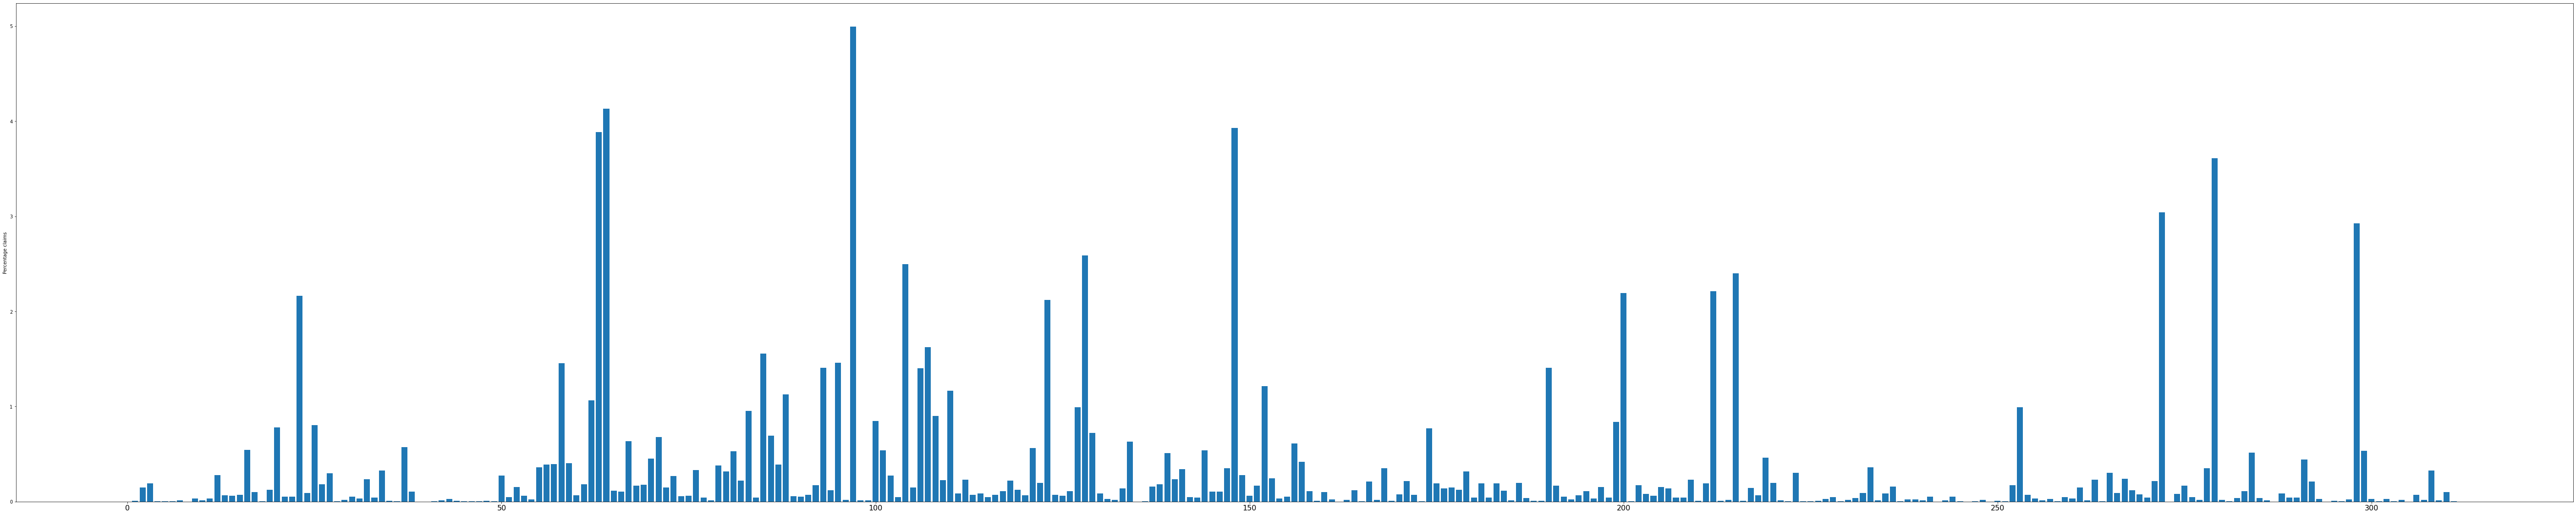

In [12]:
# read the diagnosis names into dataframe, clean up values and display records
dict_diagnosis_names = pd.read_csv('./data/anomaly-detection/DiagnosisRelatedGroupNames.csv', sep=', "', skiprows=1, names=['Base DRG code','Diagnosis related group']);
dict_diagnosis_names['Diagnosis related group'] = dict_diagnosis_names['Diagnosis related group'].map(lambda x: x.replace('"',''));
display(dict_diagnosis_names.head())
display(dict_diagnosis_names.dtypes)


# join the Base DRG code in dictionay with Base DRG code in claims dataframe and describe the distribution amongst different age group in claims dataset
tmp_diagnosis_counts = dict_diagnosis_names.set_index('Base DRG code').join( df_cms_claims_data['Base DRG code'].value_counts() )
tmp_diagnosis_counts['percentage'] = tmp_diagnosis_counts['Base DRG code']/tmp_diagnosis_counts['Base DRG code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.figure(figsize=(100,20))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_diagnosis_counts.index, tmp_diagnosis_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

Observe the distribution of different diagnosis code in above bar graph printed from claims dataset.

Next, let's do text processing on diagnosis descriptions to make some of the acronyms more meaningful for word embeddings

In [13]:
# function to run pre processing on diagnosis descriptions
from nltk.tokenize import sent_tokenize, word_tokenize 

def text_preprocessing(phrase):
    phrase = phrase.lower()
    phrase = phrase.replace('&', 'and')
    #phrase = phrase.replace('non-', 'non') #This is to ensure non-critical, doesn't get handled as {'non', 'critical'}
    phrase = phrase.replace(',','')
    phrase = phrase.replace('w/o','without').replace(' w ',' with ').replace('/',' ')
    phrase = phrase.replace(' maj ',' major ')
    phrase = phrase.replace(' proc ', ' procedure ')
    phrase = phrase.replace('o.r.', 'operating room')
    sentence = phrase.split(' ')
    return sentence

In [14]:
# run pre processing on diagnosis related group
tmp_diagnosis_tokenized = dict_diagnosis_names['Diagnosis related group'].map(lambda x: text_preprocessing(x))
display(tmp_diagnosis_tokenized.head())

0    [heart, transplant, or, implant, of, heart, as...
1    [ecmo, or, trach, with, mv, 96+, hrs, or, pdx,...
2    [trach, with, mv, 96+, hrs, or, pdx, exc, face...
3                                  [liver, transplant]
4                                   [lung, transplant]
Name: Diagnosis related group, dtype: object

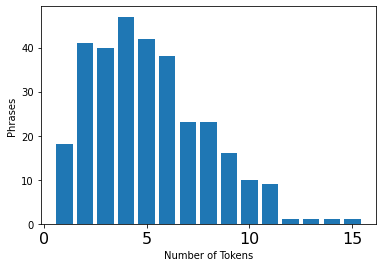

In [15]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
diagnosis_phrase_lengths = tmp_diagnosis_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(diagnosis_phrase_lengths)), diagnosis_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [16]:
# traing wordtovec model on diagnosis description tokens
model_drg = Word2Vec(tmp_diagnosis_tokenized, 
                     min_count = 1,  # Minimium frequency count of words. The model would ignore words that do not satisfy the min_count.Extremely infrequent words are usually unimportant, so its best to get rid of those.
                     size = 72,  # The size of the dense vector that is to represent each token or word. A value of 100–150 usually works ok
                     window = 5, # The maximum distance between the target word and its neighboring word. a smaller window should give you terms that are more related
                     iter = 30) # Number of Epochs 

print(model_drg)

diagnosis_words = list(model_drg.wv.vocab)
print(columnize.columnize(diagnosis_words, displaywidth=80, ljust=False))

Word2Vec(vocab=520, size=72, alpha=0.025)
          heart         pulmonary            combined         evisceration
     transplant          embolism            anterior                  rad
             or       respiratory           posterior         hysterectomy
        implant     inflammations              fusion           vulvectomy
             of           pleural                 fus              uterine
         assist          effusion                cerv               adnexa
         system             edema                curv              ovarian
           ecmo           failure               malig              adnexal
          trach           chronic               infec        uterineadnexa
           with       obstructive                  9+          non-ovarian
             mv           disease            cervical       non-malignancy
            96+            simple           bilateral                dandc
            hrs         pneumonia               joint     

#### t-Distributed Stochastic Neighbor Embedding (t-SNE)
T-SNE is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

The word2vec and t-SNE graph may not always look the same even if the parameters used to train the model are same. This is because of random initialization at the beginning of every new training session.

There is no ideal shape in which the t-SNE graph should appear. However, avoid using a pattern in which all the words appear in one single cluster very close to each other. The below graph has a good spread.

In [17]:
# plot TSNE visualization
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

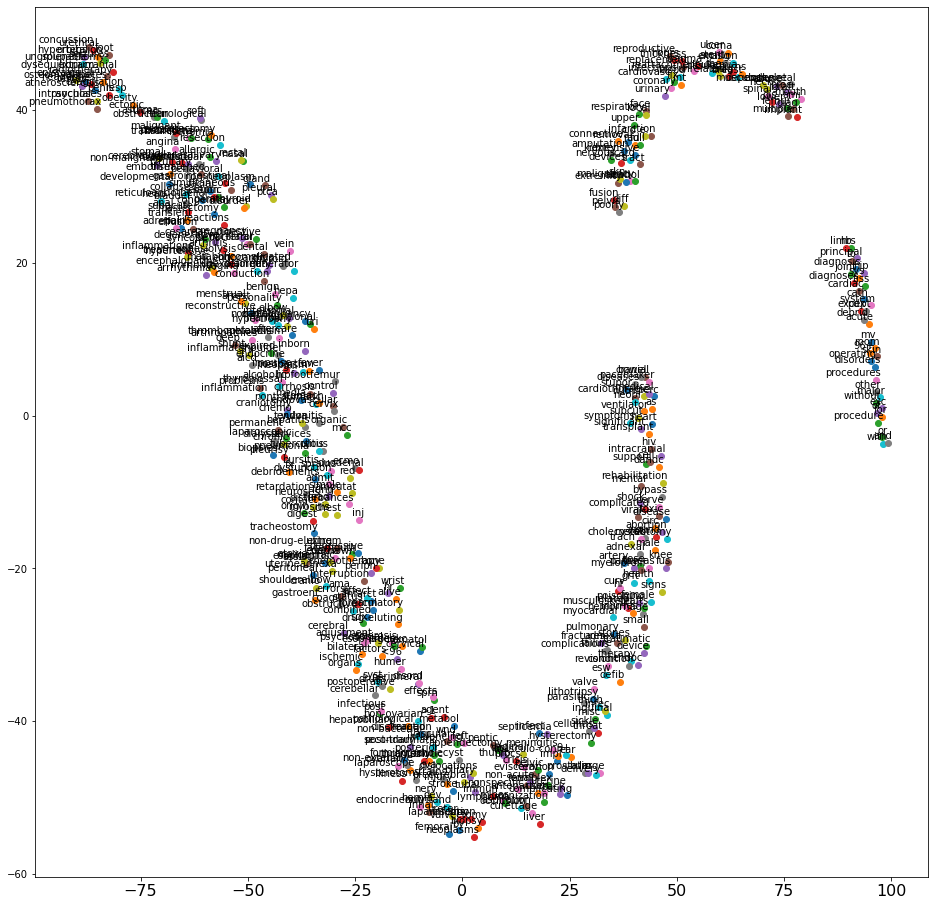

In [18]:
# plot t_SNE chart for diagnosis word to vector. 
#2D visual plot of word embeddings derieved from diagnosis description.
tsne_plot(model_drg)

In [19]:
# test most similiar for some word from model_drg.wv.keywords
model_drg.most_similar('diagnosis')

[('exc', 0.9981981515884399),
 ('or', 0.998053789138794),
 ('and', 0.9980237483978271),
 ('for', 0.997916579246521),
 ('with', 0.9979033470153809),
 ('of', 0.9978736639022827),
 ('disorders', 0.9977995157241821),
 ('room', 0.9977182149887085),
 ('major', 0.9976302981376648),
 ('other', 0.9975858330726624)]

In [20]:
# extract diagnosis words that starts with non
#display(tmp_diagnosis_tokenized.head())
series_diagnosis = pd.Series(diagnosis_words)
diagnosis_words_with_non = series_diagnosis[series_diagnosis.map(lambda x: 'non' in x)]
display(diagnosis_words_with_non)

76          nonspecific
89         nontraumatic
99        non-bacterial
183    non-drug-eluting
344       non-malignant
370        non-neoplasm
399         non-ovarian
400      non-malignancy
444           non-acute
507       non-extensive
dtype: object

In [21]:
# Check similarity between diagnosis words with opposite severity
for i in diagnosis_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in diagnosis_words:
        print('Cosine similarity between', a, not_a, ':', model_drg.wv.similarity(a, not_a))
        print('')

Cosine similarity between traumatic nontraumatic : 0.934773

Cosine similarity between bacterial non-bacterial : 0.89819175

Cosine similarity between drug-eluting non-drug-eluting : 0.9250915

Cosine similarity between malignant non-malignant : 0.3799054

Cosine similarity between neoplasm non-neoplasm : 0.8090705

Cosine similarity between ovarian non-ovarian : 0.94026685

Cosine similarity between malignancy non-malignancy : 0.9159623

Cosine similarity between acute non-acute : 0.98569137

Cosine similarity between extensive non-extensive : 0.97075635



In [22]:
# calculate mean of word vector in a phrase to derieve phrase vector for diagnosis description
# we plan to use mean of word vectors to derive word embeddings for a phrase
values = []
index =[]
#iterate through list of strings in each diagnosis phrase
for i, v in pd.Series(tmp_diagnosis_tokenized).items():
    #calculate mean of all word embeddings in each diagnosis phrase
    values.append(model_drg[v].mean(axis =0))
    index.append(i)
tmp_diagnosis_phrase_vector = pd.DataFrame({'Base DRG code':index, 'DRG_VECTOR':values})
display(tmp_diagnosis_phrase_vector.head())

,Base DRG code,DRG_VECTOR
0,0,"[-0.000917308, -0.013481122, 0.09030705, 0.023..."
1,1,"[-0.004586151, -0.018076519, 0.1359046, 0.0336..."
2,2,"[-0.004134059, -0.016903074, 0.13143754, 0.031..."
3,3,"[-0.0002992747, -0.001827001, 0.040404625, 0.0..."
4,4,"[0.0036254528, -0.004106278, 0.029919261, 0.00..."


In [23]:
# expand tmp_diagnosis_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
diagnosis_features = tmp_diagnosis_phrase_vector['DRG_VECTOR'].apply(pd.Series)

# rename each variable in diagnosis_features use DRG_F as prefix
diagnosis_features = diagnosis_features.rename(columns = lambda x : 'DRG_F' + str(x + 1))

# view the diagnosis_features dataframe
display(diagnosis_features.head())

,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,-0.000917,-0.013481,0.090307,0.023512,-0.139636,0.087390,0.183843,-0.039314,0.160997,0.117505,-0.122171,-0.128924,-0.058129,-0.005542,-0.020091,0.009575,-0.003592,0.064947,0.038331,0.007480,0.031705,-0.091702,0.059836,0.036045,0.108157,0.032641,-0.071305,0.022592,0.030833,0.017184,-0.042039,0.099035,0.040129,-0.131660,0.081102,0.040134,-0.038857,-0.040605,0.010201,0.047615,-0.072990,0.022029,-0.106072,0.012811,-0.100117,-0.083060,-0.045586,0.085798,0.021733,-0.028059,-0.021179,-0.064345,-0.110630,-0.024371,0.172533,-0.047813,0.086424,0.071501,-0.102447,-0.125354,0.060257,0.051200,0.052305,-0.004775,0.016344,0.005101,0.071180,-0.035183,-0.089670,0.018735,-0.033382,0.086094
1,-0.004586,-0.018077,0.135905,0.033681,-0.208211,0.135157,0.278233,-0.061003,0.241296,0.176765,-0.179238,-0.194117,-0.081076,-0.005501,-0.031547,0.014499,-0.003163,0.100580,0.057109,0.013639,0.050279,-0.138727,0.087342,0.056254,0.161308,0.045950,-0.113728,0.028837,0.045410,0.027080,-0.063888,0.148739,0.063198,-0.196122,0.117301,0.055205,-0.054816,-0.066520,0.016260,0.070239,-0.107337,0.038631,-0.158239,0.016191,-0.149382,-0.124039,-0.070278,0.126352,0.028155,-0.045659,-0.034005,-0.095700,-0.165800,-0.038841,0.264850,-0.073425,0.123257,0.107117,-0.156081,-0.186789,0.093786,0.077583,0.080337,-0.010883,0.020535,0.007863,0.109525,-0.051923,-0.133973,0.022203,-0.049189,0.125362
2,-0.004134,-0.016903,0.131438,0.031944,-0.200167,0.130753,0.268592,-0.058633,0.232298,0.170832,-0.173244,-0.187386,-0.078107,-0.005153,-0.030661,0.014157,-0.002384,0.096990,0.055612,0.012467,0.048729,-0.133995,0.084848,0.053967,0.156426,0.043963,-0.110757,0.028091,0.044201,0.025191,-0.061523,0.143756,0.060990,-0.189614,0.113266,0.052848,-0.052726,-0.063728,0.015086,0.066767,-0.103179,0.037240,-0.153202,0.014965,-0.144837,-0.119300,-0.067600,0.122037,0.027638,-0.044520,-0.032828,-0.092242,-0.160217,-0.037231,0.256279,-0.071217,0.119760,0.104183,-0.151136,-0.180261,0.090776,0.074820,0.077488,-0.010458,0.020696,0.008177,0.105032,-0.049685,-0.129044,0.021637,-0.047629,0.121830
3,-0.000299,-0.001827,0.040405,0.010770,-0.057090,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.006920,0.007926,-0.000317,0.026586,0.014590,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.011340,0.015815,0.007848,-0.021063,0.039356,0.013640,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.045630,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.004520,-0.004767,0.028964,-0.013490,-0.039971,0.008244,-0.018188,0.037621
4,0.003625,-0.004106,0.029919,0.009241,-0.050431,0.028134,0.057730,-0.013309,0.052584,0.040734,-0.038122,-0.040065,-0.018762,0.002737,-0.003544,0.004608,-0.000671,0.023662,0.015575,0.003591,0.010484,-0.029280,0.022593,0.013781,0.036587,0.011682,-0.020970,0.004382,0.016215,0.005130,-0.015807,0.028710,0.012067,-0.046222,0.026674,0.014025,-0.009651,-0.009672,0.001615,0.013738,-0.026857,0.003651,-0.033160,0.007658,-0.032818,-0.023708,-0.014425,0.025434,0.011662,-0.010214,-0.002804,-0.024801,-0.042059,-0.009436,0.058850,-0.013809,0.025188,0.025668,-0.034023,-0.038646,0.016746,0.014484,0.018730,0.003593,0.005059,-0.000493,0.022623,-0.012003,-0.031332,0.003916,-0.012973,0.028940


### (2) Procedure Descriptions 
Same steps as we did for 'Diagnosis Descriptions'

In [24]:
#read procedure code and procedure description mappings
dict_procedure_names = pd.read_csv('./data/anomaly-detection/InternationalClassificationOfDiseasesNames.csv', 
                              sep=', "', 
                              skiprows=1, 
                              names=['ICD9 primary procedure code','International Classification of Diseases'])

#replace double quotes with blank
dict_procedure_names = dict_procedure_names.applymap(lambda x: x.replace('"',''))

# replace -1 as code for 'No procedure performed'. In the dictionary the code is set as blank.
dict_procedure_names.iloc[0]['ICD9 primary procedure code'] = procedue_na

# convert procedure code from float to int64
dict_procedure_names['ICD9 primary procedure code'] = dict_procedure_names['ICD9 primary procedure code'].astype(np.int64)


# check the datatype for each column
display(dict_procedure_names.dtypes)

# display first five records in dictionary
display(dict_procedure_names.head())

ICD9 primary procedure code                  int64
International Classification of Diseases    object
dtype: object

,ICD9 primary procedure code,International Classification of Diseases
0,-1,No procedure performed
1,0,Not elsewhere classified
2,1,Incise-excis brain/skull
3,2,Other skull/brain ops
4,3,Spinal cord & canal ops


In [25]:
display(dict_procedure_names.count())

ICD9 primary procedure code                 101
International Classification of Diseases    101
dtype: int64

Text(0, 0.5, 'Percentage claims')

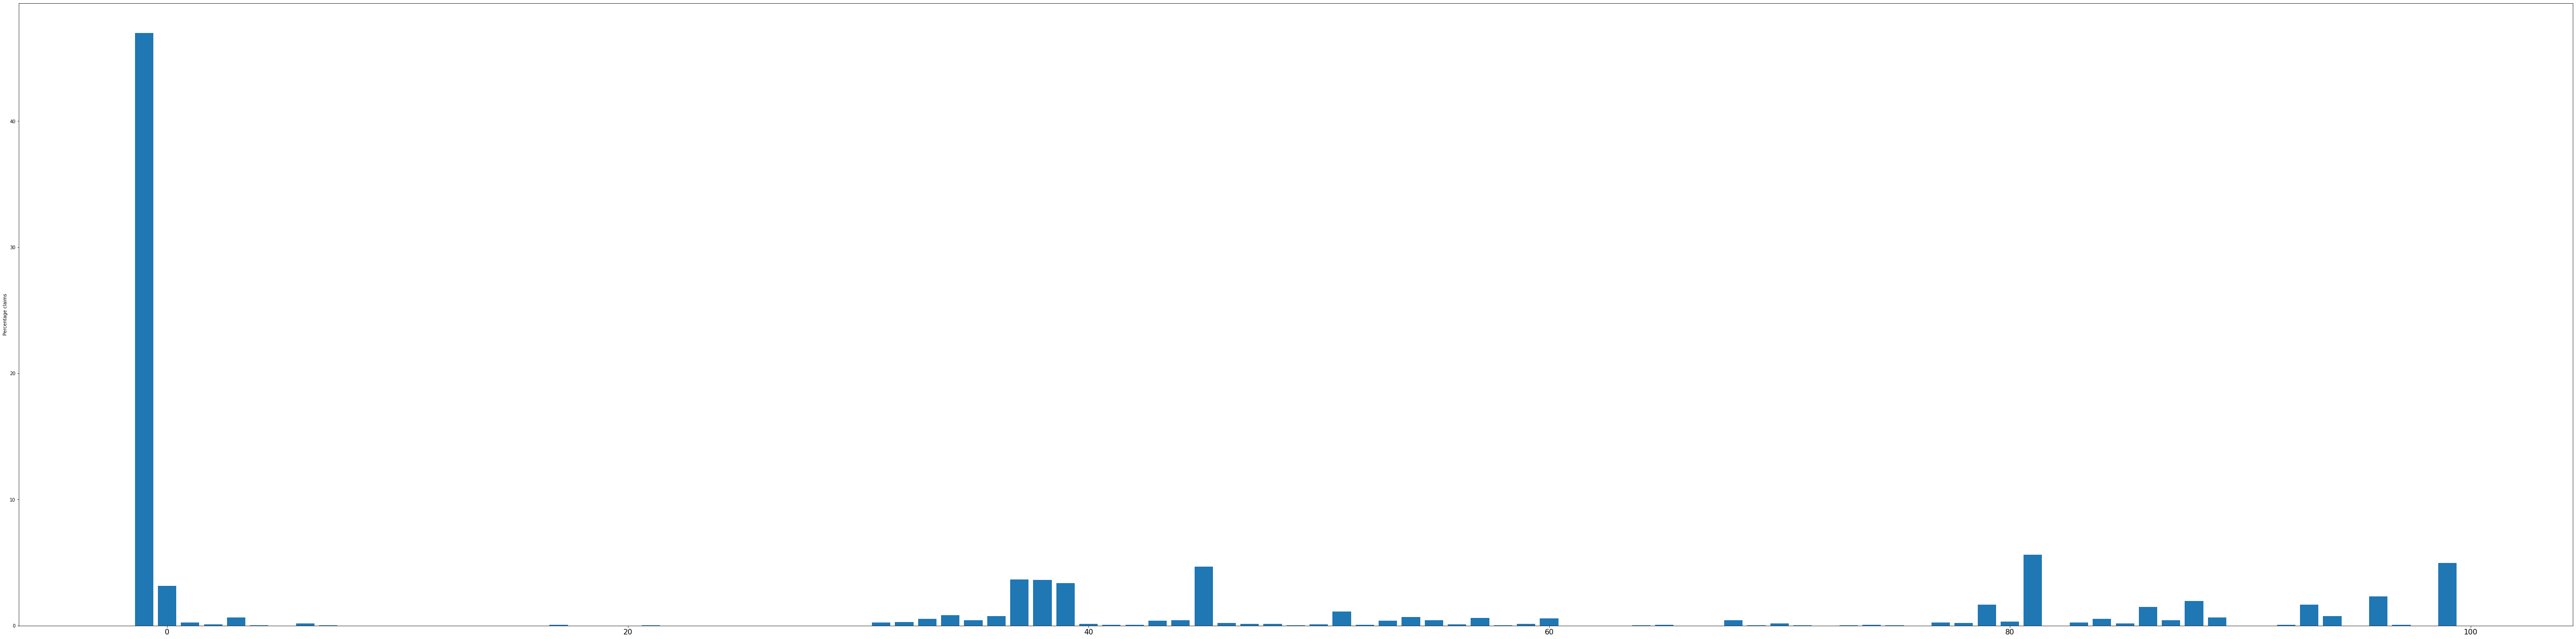

In [26]:
# join the ICD9 primary procedure code in dictionay with ICD9 primary procedure code in claims dataframe and plot the distribution of procedures in the claims dataset
tmp_procedure_counts = dict_procedure_names.set_index('ICD9 primary procedure code').join(df_cms_claims_data['ICD9 primary procedure code'].value_counts() )
tmp_procedure_counts['percentage'] = tmp_procedure_counts['ICD9 primary procedure code']/tmp_procedure_counts['ICD9 primary procedure code'].sum()*100

# project procedure distribution in the claims dataset on the bar graph
plt.figure(figsize=(100,25))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_procedure_counts.index, tmp_procedure_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [27]:
# run pre processing on procedure descriptions
tmp_procedure_tokenized = dict_procedure_names['International Classification of Diseases'].map(lambda x: text_preprocessing(x))
display(tmp_procedure_tokenized.head())

0         [no, procedure, performed]
1       [not, elsewhere, classified]
2       [incise-excis, brain, skull]
3         [other, skull, brain, ops]
4    [spinal, cord, and, canal, ops]
Name: International Classification of Diseases, dtype: object

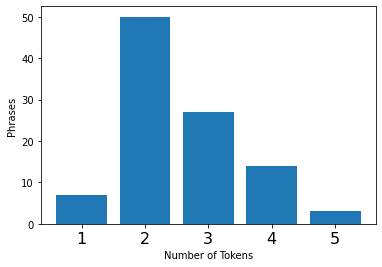

In [28]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
procedure_phrase_lengths = tmp_procedure_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(procedure_phrase_lengths)), procedure_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [29]:
# traing wordtovec model on procedure description tokens
model_prc = Word2Vec(tmp_procedure_tokenized, 
                     min_count = 1, 
                     size = 72, 
                     window = 5, 
                     iter = 100)
print(model_prc)
procedure_words = list(model_prc.wv.vocab)
print(columnize.columnize(procedure_words, displaywidth=80, ljust=False))

Word2Vec(vocab=193, size=72, alpha=0.025)
          no        segment          of      liver     cul-de-sac    diagnostic
   procedure           lens      larynx    biliary         vulvar     radiology
   performed      posterior     trachea      tract       perineal            dx
         not    extraocular         nec   pancreas         forcep     interview
   elsewhere         muscle        lung     repair            vac       consult
  classified          orbit    bronchus     hernia         breech          exam
incise-excis        eyeball   bronchial    abdomen          deliv   microscopic
       brain  miscellaneous      thorax     region         assist       exam--i
       skull     procedures      except     kidney         induce      exam--ii
       other       external       heart     ureter      c-section       nuclear
         ops            ear      valves    urinary          fetus      medicine
      spinal         middle       septa    bladder      obstetric            p

Repeat the preceding process for procedure descriptions. The following screenshot shows the 2D projection after processing and applying word2vec. Again, the graph has a good spread.

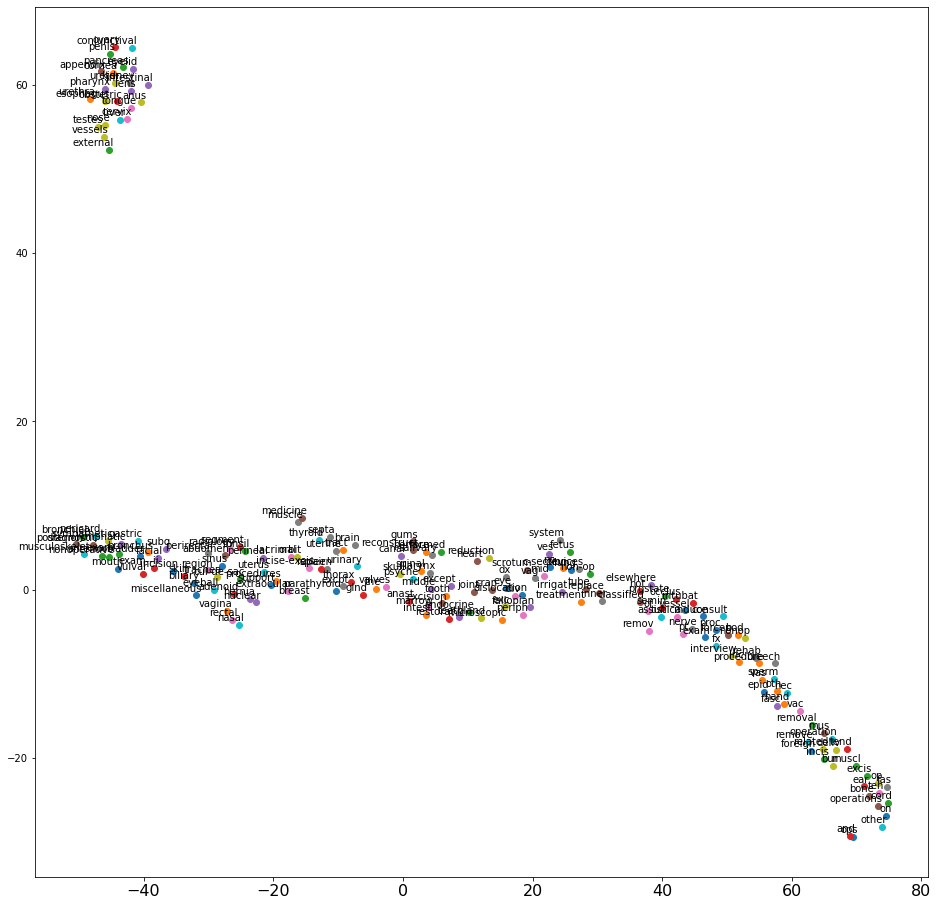

In [30]:
# plot t_SNE chart for procedure word to vector
# #2D visual plot of word embeddings derieved from procedure description.
tsne_plot(model_prc)

In [31]:
# test most similiar for some word from model_prc.wv.keywords
model_prc.most_similar('nonoperative')

[('treatment', 0.949404239654541),
 ('bur', 0.9479164481163025),
 ('proc', 0.947742760181427),
 ('bone', 0.9477335810661316),
 ('epid', 0.9467064738273621),
 ('remove', 0.946689784526825),
 ('anast', 0.9466512203216553),
 ('fx', 0.946466863155365),
 ('of', 0.9459813833236694),
 ('foreign', 0.9459385275840759)]

In [32]:
# extract procedure words that starts with non
#display(tmp_procedure_tokenized.head())
series_procedure = pd.Series(procedure_words)
procedure_words_with_non = series_procedure[series_procedure.map(lambda x: 'non' in x)]
display(procedure_words_with_non)

182          non-op
188           nonop
192    nonoperative
dtype: object

In [33]:
# Check similarity between procedure words with opposite severity
for i in procedure_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in procedure_words:
        print('Cosine similarity between', a, not_a, ':', model_prc.wv.similarity(a, not_a))
        print('')

Cosine similarity between op non-op : 0.9851273

Cosine similarity between op nonop : 0.9917493



In [34]:
# calculate mean of word vector in a phrase to derieve phrase vector for procedure description 
values = []
index =[]
#iterate through list of strings in each procedure phrase
for i, v in pd.Series(tmp_procedure_tokenized).items():
    #calculate mean of all word embeddings in each procedure phrase
    values.append(model_prc[v].mean(axis =0))
    index.append(i)
tmp_procedure_phrase_vector = pd.DataFrame({'ICD9 primary procedure code':index, 'PRC_VECTOR':values})
display(tmp_procedure_phrase_vector.head())

,ICD9 primary procedure code,PRC_VECTOR
0,0,"[-0.024151117, -0.0069636926, -0.014427583, 0...."
1,1,"[-0.025564803, -0.006499961, -0.015628157, 0.0..."
2,2,"[-0.016976131, 0.00026972688, -0.0048720194, 0..."
3,3,"[-0.044007853, -0.00816474, -0.01769754, 0.029..."
4,4,"[-0.058822952, -0.011873374, -0.0238371, 0.033..."


In [35]:
# expand tmp_procedure_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
procedure_features = tmp_procedure_phrase_vector['PRC_VECTOR'].apply(pd.Series)

# rename each variable in procedure_features use PRC_F as prefix
procedure_features = procedure_features.rename(columns = lambda x : 'PRC_F' + str(x + 1))

# view the procedure_features dataframe
display(procedure_features.head())

,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,-0.024151,-0.006964,-0.014428,0.012266,0.007243,0.028083,0.012722,-0.049869,-0.014521,0.023071,-0.046054,-0.040851,0.013093,-0.037193,-0.009517,-0.026320,-0.028960,0.016969,-0.006639,-0.011798,0.001017,0.026938,0.008497,0.069439,0.019926,-0.017240,-0.034610,0.030391,-0.012763,-0.058757,-0.001020,-0.005378,-0.014129,-0.005556,0.035849,0.081593,-0.021832,-0.038083,0.054369,-0.020471,0.021601,-0.024831,0.014305,0.019127,-0.016150,-0.015251,0.038191,0.011930,0.039054,-0.033782,0.041275,0.002241,0.072784,-0.014681,-0.005083,-0.085404,0.077468,-0.030394,-0.015857,-0.012318,0.068702,-0.011993,-0.014454,0.016127,0.015879,0.054423,-0.001470,0.022836,-0.042747,0.039589,0.038153,0.078433
1,-0.025565,-0.006500,-0.015628,0.015072,0.010794,0.032291,0.003709,-0.058008,-0.014804,0.023008,-0.051525,-0.041807,0.013035,-0.045483,-0.010305,-0.027712,-0.027116,0.020688,-0.009382,-0.011358,-0.001327,0.018666,0.017139,0.074615,0.024285,-0.017924,-0.030706,0.033755,-0.016063,-0.063651,-0.006494,-0.001772,-0.017049,-0.012341,0.034369,0.080021,-0.017788,-0.047703,0.059519,-0.021304,0.019597,-0.014011,0.018179,0.016360,-0.012236,-0.017605,0.040217,0.020807,0.045305,-0.038548,0.040289,0.003979,0.078934,-0.018120,-0.005001,-0.080965,0.074714,-0.029340,-0.020202,-0.014392,0.073407,-0.013217,-0.009550,0.010965,0.020637,0.053965,-0.003595,0.023025,-0.039247,0.029721,0.037243,0.078271
2,-0.016976,0.000270,-0.004872,0.010546,0.008496,0.017299,0.000103,-0.038692,-0.017784,0.012333,-0.030860,-0.036119,0.004678,-0.028055,-0.005075,-0.021655,-0.015534,0.017900,-0.002389,-0.009777,0.000835,0.015739,0.008524,0.055858,0.016375,-0.015766,-0.021917,0.022808,-0.015534,-0.041215,-0.001536,-0.005231,-0.014707,-0.008867,0.022289,0.057787,-0.013874,-0.027355,0.039133,-0.019142,0.012863,-0.010882,0.013314,0.007566,-0.010393,-0.011008,0.025524,0.009530,0.028155,-0.025232,0.032907,0.006136,0.054937,-0.012428,0.003047,-0.052721,0.052553,-0.021013,-0.009847,-0.009163,0.046833,-0.003926,-0.001743,0.010728,0.015041,0.032293,-0.000890,0.016332,-0.024205,0.028171,0.023866,0.048152
3,-0.044008,-0.008165,-0.017698,0.029376,0.019860,0.053036,0.005940,-0.096143,-0.035056,0.032384,-0.085616,-0.089042,0.007791,-0.071532,-0.017501,-0.051402,-0.051277,0.040934,-0.011521,-0.017619,0.005345,0.043530,0.021342,0.139075,0.046558,-0.036911,-0.053448,0.055017,-0.031744,-0.109149,-0.003726,-0.006878,-0.029138,-0.020254,0.060213,0.151927,-0.033482,-0.074527,0.107111,-0.036992,0.038387,-0.031628,0.028846,0.029114,-0.023880,-0.029347,0.071796,0.022973,0.071477,-0.066787,0.083549,0.011689,0.138979,-0.035796,-0.000731,-0.152574,0.145040,-0.058296,-0.033630,-0.029159,0.132282,-0.017664,-0.016298,0.026194,0.038381,0.094773,-0.010353,0.037709,-0.074911,0.064408,0.064327,0.135767
4,-0.058823,-0.011873,-0.023837,0.033673,0.024537,0.062036,0.011554,-0.117875,-0.038514,0.042880,-0.100417,-0.108704,0.014655,-0.091625,-0.022906,-0.061466,-0.063933,0.049175,-0.017048,-0.022916,0.001993,0.052279,0.030141,0.166094,0.055838,-0.042112,-0.063641,0.066023,-0.034677,-0.134390,-0.003530,-0.007905,-0.030882,-0.024392,0.072634,0.186800,-0.041026,-0.096915,0.129969,-0.045099,0.047409,-0.040484,0.038195,0.036814,-0.029081,-0.036207,0.087774,0.033623,0.082793,-0.080305,0.099374,0.010598,0.166926,-0.039341,-0.006246,-0.184494,0.176410,-0.067158,-0.043565,-0.036484,0.168699,-0.022586,-0.020053,0.034219,0.044786,0.116661,-0.013852,0.047671,-0.091369,0.078709,0.077610,0.

In [36]:
#merge diagnosis word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_diagnosis = pd.merge(df_cms_claims_data, diagnosis_features, how='inner', left_on = 'Base DRG code', right_index = True)
display(tmp_join_claim_diagnosis.head())

#merge procedure word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_procedure = pd.merge(tmp_join_claim_diagnosis, procedure_features, how='inner', left_on = 'ICD9 primary procedure code', right_index = True)
display(tmp_join_claim_procedure.head())

#assign new feature set with procedure and diagnosis work embeddings to a new claims feature dataframe
#aggregate all the features extrcated so far to build a final claims feature set for training
claims_features = tmp_join_claim_procedure

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621
1055,IP-00769E0F26D617F0,1,3,3,31,4,27725,1,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621
1385,IP-009C3541718DECF9,2,4,3,31,4,69162,3,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621
1474,IP-00A71BB8A6B8548E,1,5,3,31,4,86240,4,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.01

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621,-0.018424,-0.009363,-0.011456,0.008523,0.004844,0.028218,0.009442,-0.044873,-0.019347,0.016496,-0.04458,-0.04313,0.008478,-0.03588,-0.009797,-0.023752,-0.023011,0.017691,-0.003444,-0.003446,0.001749,0.021017,0.009375,0.060868,0.0187,-0.017038,-0.023605,0.026241,-0.018206,-0.051352,-0.001486,-0.007064,-0.012536,-0.005787,0.028404,0.068824,-0.012464,-0.029508,0.046521,-0.016906,0.018921,-0.01295,0.011714,0.016937,-0.010619,-0.0162,0.031512,0.014127,0.035362,-0.025329,0.040569,0.002799,0.064534,-0.01873,-0.003805,-0.076974,0.069578,-0.025878,-0.018711,-0.014646,0.067496,-0.009818,-0.008618,0.013711,0.019121,0.044398,-0.012016,0.016391,-0.035425,0.028847,0.031328,0.064359
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621,-0.018424,-0.009363,-0.011456,0.008523,0.004844,0.028218,0.009442,-0.044873,-0.019347,0.016496,-0.04458,-0.04313,0.008478,-0.03588,-0.009797,-0.023752,-0.023011,0.017691,-0.003444,-0.003446,0.001749,0.021017,0.009375,0.060868,0.0187,-0.017038,-0.023605,0.026241,-0.018206,-0.051352,-0.001486,-0.007064,-0.012536,-0.005787,0.028404,0.068824,-0.012464,-0.029508,0.046521,-0.016906,0.018921,-0.01295,0.011714,0.016937,-0.010619,-0.0162,0.031512,0.014127,0.035362,-0.025329,0.040569,0.002799,0.064534,-0.01873,-0.003805,-0.076974,0.069578,-0.025878,-0.018711,-0.

### 4. Preparing a Model 

Next, we start to create a model with a processed dataset. 

#### Train/Test Split

In [37]:
from sklearn.model_selection import StratifiedShuffleSplit

X = claims_features.drop(['Encrypted PUF ID','ICD9 primary procedure code','Base DRG code'], axis=1)
strata = claims_features['DRG quintile payment amount code']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
splits = sss.split(X, strata)
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [38]:
display(X.head())
X.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,2,4,4,86240,4,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621,-0.018424,-0.009363,-0.011456,0.008523,0.004844,0.028218,0.009442,-0.044873,-0.019347,0.016496,-0.04458,-0.04313,0.008478,-0.03588,-0.009797,-0.023752,-0.023011,0.017691,-0.003444,-0.003446,0.001749,0.021017,0.009375,0.060868,0.0187,-0.017038,-0.023605,0.026241,-0.018206,-0.051352,-0.001486,-0.007064,-0.012536,-0.005787,0.028404,0.068824,-0.012464,-0.029508,0.046521,-0.016906,0.018921,-0.01295,0.011714,0.016937,-0.010619,-0.0162,0.031512,0.014127,0.035362,-0.025329,0.040569,0.002799,0.064534,-0.01873,-0.003805,-0.076974,0.069578,-0.025878,-0.018711,-0.014646,0.067496,-0.009818,-0.008618,0.013711,0.019121,0.044398,-0.012016,0.016391,-0.035425,0.028847,0.031328,0.064359
272,1,1,4,56756,2,-0.000299,-0.001827,0.040405,0.01077,-0.05709,0.034578,0.069815,-0.012259,0.062663,0.048744,-0.053227,-0.052223,-0.024344,0.001875,-0.00692,0.007926,-0.000317,0.026586,0.01459,0.005697,0.010275,-0.032922,0.026942,0.012288,0.038848,0.011448,-0.024723,0.01134,0.015815,0.007848,-0.021063,0.039356,0.01364,-0.055721,0.036514,0.018074,-0.017395,-0.016025,0.000462,0.018049,-0.034705,0.004076,-0.04563,0.006269,-0.039853,-0.030487,-0.015255,0.030385,0.010413,-0.010586,-0.010379,-0.025304,-0.045632,-0.016471,0.070936,-0.021376,0.036271,0.025723,-0.044206,-0.047988,0.021578,0.020342,0.020189,-0.000702,0.00452,-0.004767,0.028964,-0.01349,-0.039971,0.008244,-0.018188,0.037621,-0.018424,-0.009363,-0.011456,0.008523,0.004844,0.028218,0.009442,-0.044873,-0.019347,0.016496,-0.04458,-0.04313,0.008478,-0.03588,-0.009797,-0.023752,-0.023011,0.017691,-0.003444,-0.003446,0.001749,0.021017,0.009375,0.060868,0.0187,-0.017038,-0.023605,0.026241,-0.018206,-0.051352,-0.001486,-0.007064,-0.012536,-0.005787,0.028404,0.068824,-0.012464,-0.029508,0.046521,-0.016906,0.018921,-0.01295,0.011714,0.016937,-0.010619,-0.0162,0.031512,0.014127,0.035362,-0.025329,0.040569,0.002799,0.064534,-0.01873,-0.003805,-0.076974,0.069578,-0.025878,-0.018711,-0.014646,0.067496,-0.009818,-0.008618,0.013711,0.019121,0.044398,-0.012016,0.016391,-0.035425,0.028847,0.031328

(311869, 149)

#### Normalize the data based on training sample 
Because the PCA algorithm that we will use later for training maximizes the orthogonal variances of one's data, it is important to standardize the training data to have zero-mean and unit-variance prior to performing PCA. This way your PCA algorithm is idempotent to such rescalings, and prevent variables of large scale from dominating the PCA projection.

In [39]:
n_obs, n_features = X_train.shape

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_stndrd_train = scaler.transform(X_train)
X_stndrd_train = pd.DataFrame(X_stndrd_train, index=X_train.index, columns=X_train.columns)

#### PCA (in SageMaker)
The built-in PCA algorithm of SageMaker solves for the singular values, $s$, and for the Principal Components, $V$, of our data set. Here we'll perform SageMaker PCA on our standardized training dataset $\tilde{X}$, and then we'll use its outputs to project our correlated dataset into a decorrelated one.

Amazon SageMaker PCA is an unsupervised ML algorithm that reduces the dimensionality (number of features) within a dataset while still retaining as much information as possible. It does this by finding a new set of features called components, which are composites of the original features that are uncorrelated with one another. They are also constrained so that the first component accounts for the largest possible variability in the data, the second component accounts for the second most variability, and so on.

The output model trained on data using Amazon SageMaker PCA calculates how each variable is associated with one another (covariance matrix), the directions in which data disperses (eigenvectors), and the relative importance of these different directions (eigenvalues).

In [41]:
X_stndrd_train

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
294047,-1.091073,-0.261926,1.358837,-0.527719,-1.525237,-0.260944,-0.927455,0.644016,1.026520,-0.573691,0.621914,0.599374,-0.731467,0.534477,0.547864,-0.646093,-0.631753,-0.551845,0.280064,-0.289746,0.068477,-0.584932,0.660486,0.692027,1.234054,0.683976,-0.568940,0.577061,0.650748,0.568769,0.980715,-0.534711,0.642083,0.944857,0.862504,-0.563391,0.569011,0.478107,-0.562278,0.642590,0.528163,-0.613516,-0.809881,-0.055520,0.826163,-0.536276,0.407145,-0.567611,0.015056,-0.591859,-0.724789,-0.690936,0.584430,0.322598,-0.697987,-0.624876,-0.531351,-0.702713,-0.653938,0.633874,-0.615579,0.602945,0.451639,-0.525126,-0.554737,0.579188,0.513499,0.546068,-1.188807,1.440134,0.723552,0.680283,-0.330807,-0.544486,-0.074366,-0.527961,0.447131,1.409559,-0.497009,1.782597,-0.960133,-1.524554,-1.532769,0.180189,1.468504,1.522441,-1.206746,1.303204,1.191878,-0.728264,1.206852,1.280795,0.893736,1.441866,-0.896766,1.818584,0.736508,-0.744164,-1.474732,-1.261039,-1.462825,-1.258471,1.919334,1.195974,-1.267575,0.951864,1.403906,0.396978,1.376970,1.230455,0.806032,-1.284292,-1.308197,1.216367,1.643399,-1.331798,0.923571,-1.325245,2.352299,-1.197078,-1.409139,0.639509,0.836421,-1.573873,-1.441846,-1.143124,1.328922,-1.245398,-0.472451,-1.379091,1.363666,-2.477281,1.436737,-1.393426,1.463837,1.349177,1.398408,-1.330111,1.276170,0.754451,-1.293056,-1.120388,-1.176908,-0.444314,-1.488624,1.157646,-1.246515,-1.455077,-1.414879
57872,-1.091073,1.459495,-0.627204,0.410172,1.294494,2.517412,1.100013,-0.922058,-1.048511,0.995831,-1.067286,-1.042224,0.625128,-0.897324,-1.000277,0.929220,1.013334,1.000091,1.812862,0.852947,-0.368816,-1.038976,-1.210991,-0.838202,-2.300179,-0.607714,0.989252,-0.849009,-0.984713,-0.901463,-1.195501,0.865592,-1.321248,-0.785184,-1.094447,0.934664,-1.034248,-0.699313,1.067428,-0.962441,-0.717552,0.914730,1.211266,-1.072170,-1.046091,0.956406,-1.503119,0.977058,0.400376,1.018128,1.049075,0.730438,-0.978628,-1.104460,0.747238,0.967217,0.757939,1.036760,0.803437,-0.941697,0.874723,-1.009920,-1.204386,0.980896,1.034459,-1.034373,-1.010068,-1.183055,-0.363452,-0.899524,-1.783533,-1.062184,1.119072,1.042565,-1.193953,0.939609,-0.981829,1.900118,3.260568,2.367638,-1.309048,-1.825239,-1.945044,-2.233391,1.870832,2.506078,-1.820877,2.026661,2.102550,-3.355362,2.238493,3.379881,1.505628,1.711085,-2.241275,1.706097,1.630706,1.328095,-2.306247,-1.915570,-2.133359,-2.320325,1.499858,2.346595,-2.252666,2.516499,2.387848,1.778419,0.553661,1.384704,1.924957,-2.396073,-1.996778,2.364798,1.838403,-2.151763,2.456648,-1.979542,2.438196,-1.442671,-2.498559,1.297819,2.827782,-1.948950,-1.765859,-2.080733,2.206414,-2.118501,-1.632649,-2.298911,1.775019,0.812642,2.231986,-2.134151,2.169446,1.594121,2.0

In [ ]:
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train3')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test3')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

### 5. Upload Data to S3

In [81]:
# change to matrix
matrx_train = X_stndrd_train.values.astype('float32')

%%time
# Convert data to Protobuf (binary stream) and upload to S3.
def writeDatasetToProtobuf(X, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(matrx_train, bucket, prefix, key)    
  
print(train_data)

output_location  = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

s3://sagemaker-us-west-2-570447867175/PCA_anomaly/fraud_anomaly_identification
training artifacts will be uploaded to: s3://sagemaker-us-west-2-570447867175/PCA_anomaly/output


In [82]:
from sagemaker.amazon.amazon_estimator import get_image_uri
# select the algorithm container based on this notebook's current location

container = get_image_uri(region, 'pca', 'latest')

print('Using SageMaker PCA container: {} ({})'.format(container, region_name))

Using SageMaker PCA container: 174872318107.dkr.ecr.us-west-2.amazonaws.com/pca:latest (us-west-2)


### 6. Create a Model

In [83]:
num_obs, feature_dim = np.shape(matrx_train)
num_components = feature_dim-1
algorithm_mode='regular'
platform='sagemaker'

pca = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=sess)

#### Hyperparamter Setup

In [84]:
pca.set_hyperparameters(feature_dim=feature_dim,
                        num_components=num_components,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=200)
start = time.time()
print('Start timestamp of launch: '+ str(start))

Start timestamp of launch: 1596077458.0416892


### 7. Start Training

In [85]:
pca.fit({'train': train_data})

stop = time.time()
total_time = stop-start
print('%2.2f minutes' %(total_time/60))

2020-07-30 02:51:03 Starting - Starting the training job...
2020-07-30 02:51:05 Starting - Launching requested ML instances.........
2020-07-30 02:52:39 Starting - Preparing the instances for training.........
2020-07-30 02:54:37 Downloading - Downloading input data
2020-07-30 02:54:37 Training - Downloading the training image...
2020-07-30 02:55:07 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[07/30/2020 02:54:59 INFO 139972923565888] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[07/30/2020 02:54:59 INFO 139972923565888] Reading provided configuration from /opt/ml/input/config/hyperparameters.js

##### When the training job is complete, SageMaker writes the model artifact to the specified S3 output location. Let's download and unpack returned PCA model artifact.

In [86]:
job_name = pca.latest_training_job.name
os.system('aws s3 cp {}/{}/output/model.tar.gz ./'.format(output_location, job_name))

# download to local directory
!tar xvzf model.tar.gz

pca_model = mx.ndarray.load('model_algo-1')
print('PCA model artifact:', pca_model.keys())

PCA model artifact: dict_keys(['s', 'v'])


x model_algo-1


#### Plotting PCA components to reduce dimensionality further
PCA can be further used to reduce the dimensionality of the problem. We have $P$ features and $P-1$ components, but we'll see in the plot below that many of the components don't contribute much to the explained variance of the data. 

Keep only the 𝐾 leading components, which explain 95% of the variance in your data.

13 components explain **95.298%** of the data’s variance. The red dotted line in the following graph highlights the cutoff required for 95% of the data’s variance.

13 components explain 95.29% of the data's variance.


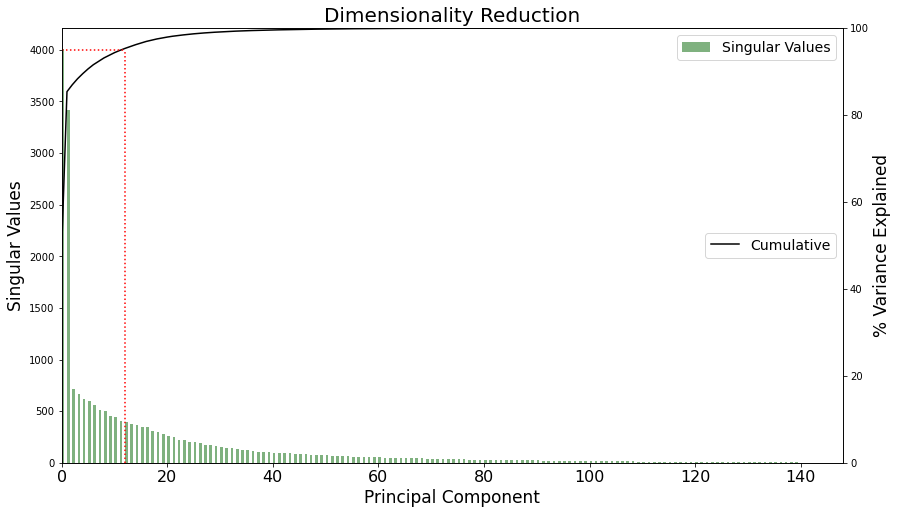

In [87]:
singular_values = pca_model['s'].asnumpy()[::-1]
pc_reversedorder = pd.DataFrame(pca_model['v'].asnumpy())
pc = pc_reversedorder[list(pc_reversedorder.columns[::-1])]

eigenvalues = np.power(singular_values,2)
explained_var_pct = eigenvalues/np.sum(eigenvalues) *100
explained_var_cum = np.cumsum(explained_var_pct)

var_threshold = 95
n_components = np.min([np.where(explained_var_cum>=var_threshold)[0][0], n_features-1])
print('%i components explain %2.2f%% of the data\'s variance.' %(n_components+1, explained_var_cum[n_components]))

fig= plt.figure(figsize=[14,8])
width = 0.5
ax1 = fig.add_subplot(111)
ax1.bar(np.arange(0,len(singular_values)), singular_values, align='edge',  color='darkgreen', label='Singular Values', alpha=0.5, width=width);
ax1.set_ylabel('Singular Values', fontsize=17);
ax1.set_xlabel('Principal Component', fontsize=17);
ax1.legend(loc='upper right', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(np.arange(0,len(explained_var_cum)), explained_var_cum, color='black',  label='Cumulative');
ax2.plot([0, n_components], [var_threshold, var_threshold], 'r:')
ax2.plot([n_components, n_components], [0, var_threshold], 'r:')
ax2.set_ylabel('% Variance Explained', fontsize=17);
ax2.legend(loc='right', fontsize=14)
ax2.set_ylim([0, 100])
ax2.set_xlim([0,len(eigenvalues)])
plt.title('Dimensionality Reduction', fontsize=20);

In [88]:
# We will now work with the reduced matrix that includes components that explains 95% of variance in the data
Vk = pc[pc.columns[:n_components+1]]

### 8. Calculating the Mahalanobis distance to score anomaly for each claim
This post uses the Mahalanobis distance of each point as its anomaly score. Take the top 𝛼% of these points to consider as outliers, where 𝛼 depends on how sensitive you want your detection to be. This post takes the top 1%, 𝛼=0.01. Therefore, calculate the (1−𝛼)-quantile of Distribution 𝐷 as the threshold for considering a data point anomalous.

The following graph was generated based on the Mahalanobis distance derived from the feature set that is the output of the Amazon SageMaker PCA algorithm. The red line describes the threshold for anomaly detection based on sensitivity defined by 𝛼

Details: https://homepages.laas.fr/owe/METROSEC/DOC/FDM03.pdf

5.741417924571194


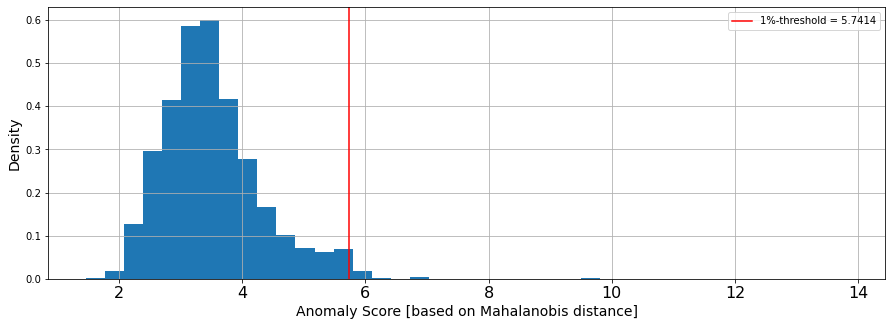

In [89]:
# Z is the PCA-projected standardized data
pca_projected_X_train = pd.DataFrame(np.dot(X_stndrd_train, Vk), index=X_stndrd_train.index)

# Calculate Mahalanobis distance for multi-variate deviation
Zmean = pca_projected_X_train.mean()
covZ = pca_projected_X_train.cov()
invcovZ = inv(covZ)
M = pca_projected_X_train.apply(lambda x: sp.spatial.distance.mahalanobis(x, Zmean, invcovZ), axis=1)

# Threshold the training set's top alpha-%
alpha = 0.01
threshold = np.quantile(M, 1-alpha)
print(threshold)

# Plot the density graph for anomaly score and highlight the threshold calculated
plt.figure(figsize=[15,5]);
M.hist(bins=40, density=True);
plt.axvline(threshold, color='red', label='{}%-threshold = {}'.format(int(alpha*100), round(threshold,4)));
plt.legend();
plt.xlabel(r'Anomaly Score [based on Mahalanobis distance]', fontsize=14);
plt.ylabel('Density', fontsize=14);

Using the anomaly score derived from the Mahalanobis distance and the sensitivity, you can label the claim as “is anomaly” TRUE/FALSE. Records with “anomalous” TRUE clear the threshold for anomaly and should be considered suspicious. “anomalous” FALSE records don’t clear the threshold and are not considered suspicious. This separates anomalous claims from standard claims.

And we want to calculate it on our Test-set

We create a function below, which transforms the test data according the models fit on. the training data. The function calcAnomalyScore() performs the following:

- standardizes each test data point according to the training mean and training standard deviation
- projects each test data point using the PCs calculated from the training data
- measures the Mahalanobis distance of each test data point from the training distribution $D$
- a boolean if the test data point's anomaly score exceeds the threshold

In [90]:
def calcAnomalyScore(data, threshold, scaler=scaler, pc=Vk, Zmean=Zmean, invcovZ=invcovZ):
    data_stndrd = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)
    pc_projected_data = pd.DataFrame(np.dot(data_stndrd, Vk), index=data_stndrd.index)
    anomaly_score = pc_projected_data.apply(lambda x: sp.spatial.distance.mahalanobis(x, Zmean, invcovZ), axis=1)
    is_anomaly = (anomaly_score>threshold)
    y = pd.concat([anomaly_score, is_anomaly], axis=1)
    y.columns = ['anomaly_score','is_anomaly']
    return y


y_test = calcAnomalyScore(X_test, threshold, scaler=scaler, pc=Vk, Zmean=Zmean, invcovZ=invcovZ)
print('Fraction of test data flagged as anomalous:', y_test['is_anomaly'].mean())

Fraction of test data flagged as anomalous: 0.009779715907269055


### 9. Understanding Anomaly (Plotting and analyzing anomalous records)
Using the sequence of actions you performed on the CMS claims dataset, you can tag anomalous claim records based on purely mathematical techniques and without unlabeled data.

Data points marked TRUE for "is_anomaly" can be passed on for inspection. Given that we now have separated norm data from anomalous data, we can contrast these to see if the differentiating reasons can be identified in the original feature space.

We attach the "is_anomaly" output as a label to the original claims feature data

In [91]:
#list all claims with anomaly score and anomaly label(True)
y_test['anomalous'] = (y_test['is_anomaly']*1.).astype(int)

test_claims = claims_features.loc[y_test.index]
test_claims = y_test.merge(test_claims, how='outer', left_index=True, right_index=True)
test_claims = test_claims.filter(["anomalous","DRG quintile payment amount code","DRG quintile average payment amount","Inpatient days code","ICD9 primary procedure code","Base DRG code","Beneficiary Age category code","Beneficiary gender code"])
display(test_claims.head())

,anomalous,DRG quintile payment amount code,DRG quintile average payment amount,Inpatient days code,ICD9 primary procedure code,Base DRG code,Beneficiary Age category code,Beneficiary gender code
335309,0,3,9488,4,38,272,5,1
13750,0,1,5883,2,81,148,4,2
432535,0,5,17457,4,38,272,5,2
393329,0,1,10222,2,81,308,4,2
365527,0,5,8986,4,89,63,6,1


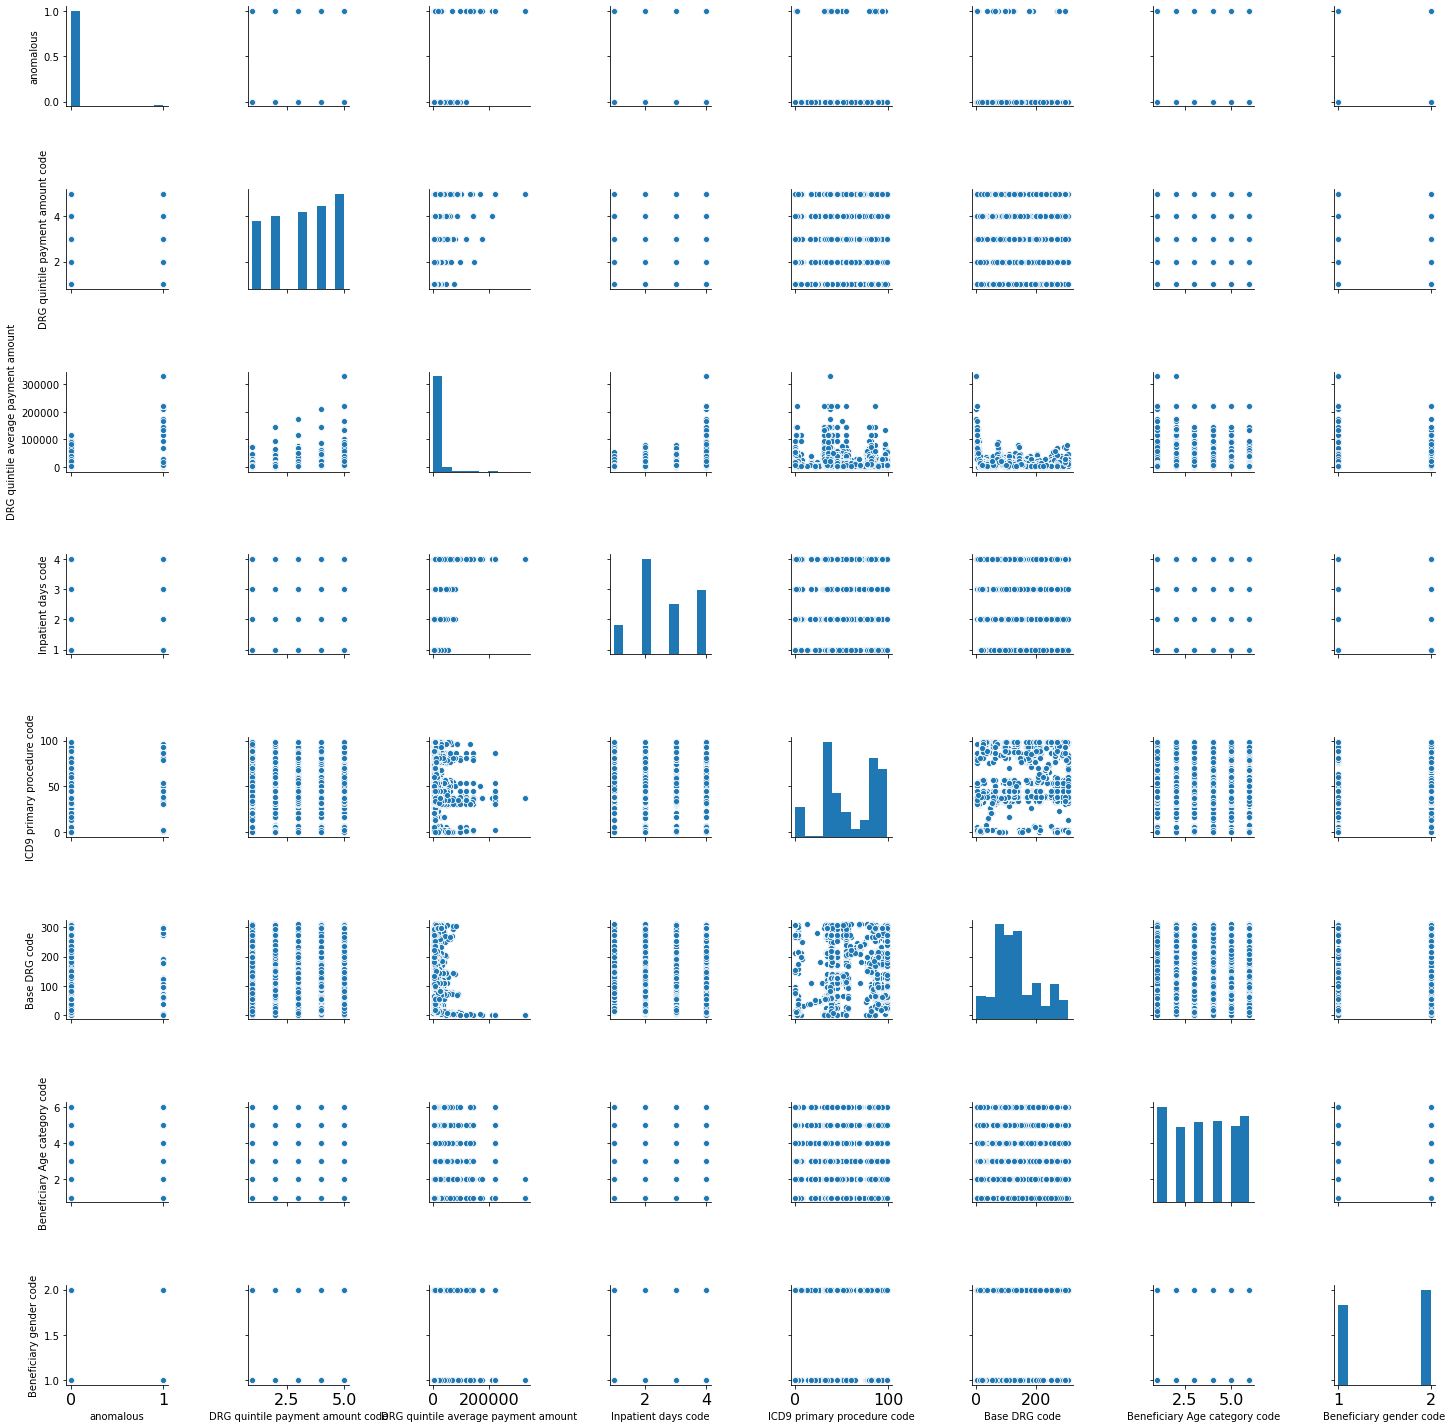

In [98]:
sns.pairplot(test_claims, kind='scatter')

In the above pair plot, look for following patterns:

- Plots where orange is asymmetrical with blue.
- Orange appears in patches that doesn't overlap with the blue

The above patterns in the pairplot can be used a starting point to target investigation on specific cases.

### 10. Deploy the model (PCA)

You may find this step helpful if you want to use principal components of claims data to predict other variables of business significance. Example, find out length of stay based on diagnosis code, gender and age or predict the claims payment amount and quartile based on datapoints in the claims dataset.

Here we demonstrate how to deploy PCA model as an endpoint on Amazon Sagemaker for inference. But, to solve the example problems discussed in the above paragraph you will need to collect more data, label them and refactor your training based on the prediction problem.

In [100]:
#serialize test data to binary format for realtime inference for extracting principal components of claim features
X_stndrd_test = scaler.transform(X_test)
X_stndrd_test = pd.DataFrame(X_stndrd_test, index=X_test.index, columns=X_test.columns)
inference_input = X_stndrd_test.values.astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, inference_input)
buf.seek(0)

0

In [101]:
#print the shape of inference_input matrix 
inference_input.shape

(93561, 149)

In [102]:
# Deploy the Amazon Sagemaker PCA model trained above to create a hosted enpoint for realtime principal component extraction
pca_predictor = pca.deploy(initial_instance_count=1,
                           instance_type='ml.p2.xlarge')

from sagemaker.predictor import csv_serializer, json_deserializer

pca_predictor.content_type = 'text/csv'
pca_predictor.serializer = csv_serializer
pca_predictor.deserializer = json_deserializer

---------------!

#### run inference on first 500 claims.

In [ ]:
# Avoid running it on large number of claims to avoid timeout on connection. 
# For large dataset use Amazon Sagemaker batch inference
result = pca_predictor.predict(inference_input[0:500])
print(result)

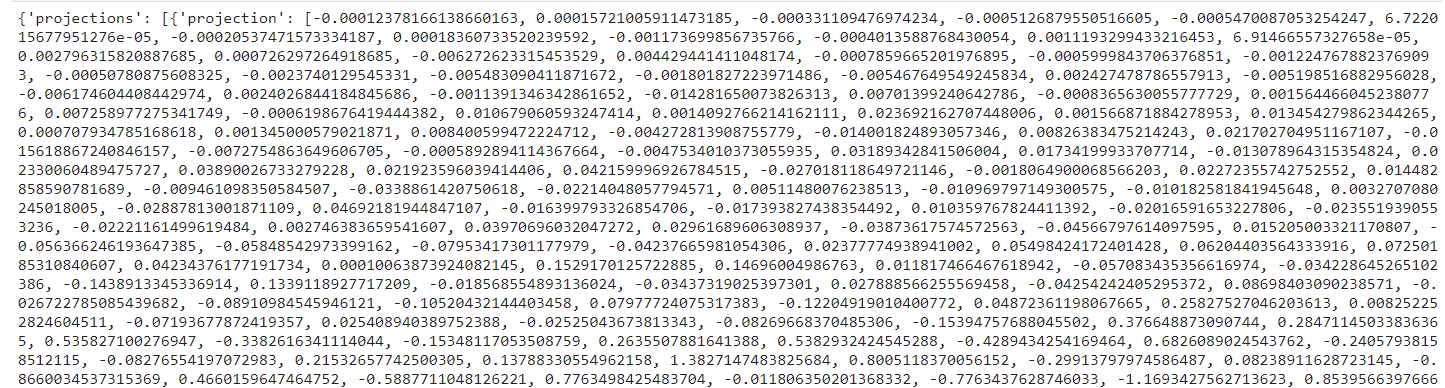

In [127]:
file_name2 = './img/testresult.png'
Image(file_name2)

In [128]:
#normalize above result in json format to more readable columar format with one principal component per column
from pandas.io.json import json_normalize
#result in json format and components are returned as a list under projections tag
result_normalized = json_normalize(result,'projections')
# expand df.tags into its own dataframe
pca_components = result_normalized['projection'].apply(pd.Series)
# rename each variable in pc
pca_components = pca_components.rename(columns = lambda x : 'PC_' + str(x))
#view the tags dataframe
pca_components

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33,PC_34,PC_35,PC_36,PC_37,PC_38,PC_39,PC_40,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_50,PC_51,PC_52,PC_53,PC_54,PC_55,PC_56,PC_57,PC_58,PC_59,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,PC_79,PC_80,PC_81,PC_82,PC_83,PC_84,PC_85,PC_86,PC_87,PC_88,PC_89,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100,PC_101,PC_102,PC_103,PC_104,PC_105,PC_106,PC_107,PC_108,PC_109,PC_110,PC_111,PC_112,PC_113,PC_114,PC_115,PC_116,PC_117,PC_118,PC_119,PC_120,PC_121,PC_122,PC_123,PC_124,PC_125,PC_126,PC_127,PC_128,PC_129,PC_130,PC_131,PC_132,PC_133,PC_134,PC_135,PC_136,PC_137,PC_138,PC_139,PC_140,PC_141,PC_142,PC_143,PC_144,PC_145,PC_146,PC_147
0,-0.000124,0.000157,-0.000331,-0.000513,-0.000547,0.000067,-0.000205,0.000184,-0.001174,-0.000401,0.001119,0.000069,0.002796,0.000726,-0.006273,0.004429,-0.000786,-0.000600,-0.001225,-0.000508,-0.002374,-0.005483,-0.001802,-0.005468,0.002427,-0.005199,-0.006175,0.002403,-0.001139,-0.014282,0.007014,-0.000837,0.001564,0.007259,-0.000620,0.010679,0.001409,0.023692,0.001567,0.013454,0.000708,0.001345,0.008401,-0.004273,-0.014002,0.008264,0.021703,-0.015619,-0.007275,-0.000589,-0.004753,0.031893,0.017342,-0.013079,0.023301,0.038900,0.021924,0.042160,-0.027018,-0.001806,0.022724,0.014483,-0.009461,-0.033886,-0.022140,0.005115,-0.010970,-0.010183,0.003271,-0.028878,0.046922,-0.016400,-0.017394,0.010360,-0.020166,-0.023552,-0.022212,0.002746,0.039707,0.029617,-0.038736,-0.045668,0.015205,-0.056366,-0.058485,-0.079534,-0.042377,0.023778,0.054984,0.062044,0.072502,0.042344,0.000101,0.152917,0.146960,0.011817,-0.057083,-0.034229,-0.143891,0.133912,-0.018569,-0.034373,0.027889,-0.042542,0.086984,-0.026723,-0.089110,-0.105204,0.079777,-0.122049,0.048724,0.258275,0.008252,-0.071937,0.025409,-0.025250,-0.082697,-0.153948,0.376649,0.284711,0.535827,-0.338262,-0.153481,0.263551,0.538293,-0.428943,0.682609,-0.240579,-0.082766,0.215327,0.137883,1.382715,0.800512,-0.299138,0.082389,-0.866003,0.466016,-0.588771,0.776350,-0.011806,-0.776344,-1.169343,0.853957,0.261141,-0.540883,0.611434,-0.956093,12.371168
1,0.000015,0.000032,0.000020,-0.000102,-0.000086,0.000112,0.000105,0.000101,0.000118,0.000178,-0.000079,0.000387,0.000032,0.000078,-0.000490,-0.000393,-0.000176,0.001059,-0.001330,-0.000828,0.000490,-0.000206,-0.002030,0.001205,-0.001735,0.000244,-0.000973,0.000277,-0.001213,-0.000212,-0.002477,-0.001751,0.000141,-0.000844,0.000527,0.001052,0.000815,-0.002896,-0.006518,0.004381,-0.004557,-0.000936,-0.000687,0.004261,0.002020,-0.000209,-0.001372,0.004556,-0.006101,0.002528,-0.002574,-0.000450,-0.003500,0.004744,-0.003733,0.002090,0.004072,0.005434,-0.008224,-0.002556,0.003500,-0.003536,-0.009892,0.012617,0.010528,-0.005085,-0.015048,0.001744,0.005026,-0.021053,0.011363,-0.002053,0.015309,0.011339,0.012746,0.004474,0.005991,-0.006411,0.001914,0.000631,0.006989,0.017927,-0.001965,0.000116,0.005347,0.012699,-0.009778,0.032181,0.005543,0.029569,0.014887,0.004069,0.027592,0.011367,-0.011142,0.007861,-0.003484,0.062927,0.033109,0.001731,0.054831,-0.014964,-0.079712,0.078544,0.012241,0.027775,-0.022032,-0.073390,-0.007032,-0.016691,0.037901,0.028291,-0.001179,0.022379,0.010418,-0.112307,-0.023337,0.127848,0.091554,0.107909,-0.015414,0.028952,-0.065683,0.047998,0.016741,0.059188,-0.170344,-0.002416,0.052085,-0.032814,0.320639,0.230549,0.115960,0.073116,-0.064968,-0.707737,0.541624,0.534834,-0.266717,0.163126,-1.470437,2.115222,-0.015590,-0.192590,-1.794824,-1.665237,5.454788,-12.044755
2,-0.000105,0.000181,-0.000282,-0.000362,-0.000480,0.000023,-0.000182,0.000162,-0.000930,-0.000245,0.001332,0.000350,0.002399,0.000682,-0.006742,0.003841,-0.001343,-0.001217,-0.001762,-0.000730,-0.002918,-0.006855,-0.001542,-0.004303,0.002757,-0.004557,-0.006590,

### 11. Close the Sagemaker Instance

In [129]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

Reference:
https://aws.amazon.com/ko/blogs/machine-learning/flagging-suspicious-healthcare-claims-with-amazon-sagemaker/